# 09g: Path Prediction Analysis

**Key Question:** Can we predict the final basin from early moves? At what depth does prediction stabilize?

**Analyses:**
1. **Basin Prediction by Depth**: Train classifier at each trick, measure accuracy
2. **Path Continuation Entropy**: How predictable is the next move given a prefix?
3. **Counterfactual Analysis**: How much do alternative paths diverge?

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy
from collections import defaultdict
from tqdm.notebook import tqdm
import random
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files - prefer val/test (smaller files)
val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

# Shuffle and combine
all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 50
MAX_ROWS = 30_000_000
print(f"Using up to {N_SHARDS} shards for analysis")

Shard files: 95 val, 95 test, 1124 train
Using up to 50 shards for analysis


## Data Collection

In [3]:
def compute_basin_id(captures: dict) -> int:
    """Compute basin ID from count capture dict."""
    basin_id = 0
    for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
        if domino_id in captures and captures[domino_id] == 1:
            basin_id |= (1 << i)
    return basin_id


def trace_path_data(start_state, seed, decl_id, state_to_idx, V, Q):
    """Trace PV and return actions, V trajectory, and Q-gaps."""
    pv = navigation.trace_principal_variation(
        start_state, seed, decl_id, state_to_idx, V, Q
    )
    
    actions = []
    v_traj = []
    q_gaps = []
    
    for state, v, action in pv:
        v_traj.append(v)
        if action is not None and action >= 0:
            actions.append(action)
            # Compute Q-gap at this state
            if state in state_to_idx:
                idx = state_to_idx[state]
                qs = Q[idx]
                valid_qs = qs[qs > -128]
                if len(valid_qs) > 1:
                    sorted_qs = np.sort(valid_qs)[::-1]
                    q_gaps.append(sorted_qs[0] - sorted_qs[1])
                else:
                    q_gaps.append(0)
            else:
                q_gaps.append(0)
    
    return actions, v_traj, q_gaps


# Collect paths
path_data = []
SAMPLES_PER_SHARD = 100
MIN_PATHS_NEEDED = 500

skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    if len(path_data) >= MIN_PATHS_NEEDED:
        break
    
    df, seed, decl_id = schema.load_file(shard_file)
    
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    depths = features.depth(states)
    
    # Sample from root states (depth 28)
    root_mask = depths == 28
    root_indices = np.where(root_mask)[0]
    
    if len(root_indices) == 0:
        del df, state_to_idx, V, Q
        gc.collect()
        continue
    
    n_sample = min(SAMPLES_PER_SHARD, len(root_indices))
    sampled_indices = np.random.choice(root_indices, n_sample, replace=False)
    
    for idx in sampled_indices:
        state = states[idx]
        
        # Get path data
        actions, v_traj, q_gaps = trace_path_data(state, seed, decl_id, state_to_idx, V, Q)
        
        # Get basin
        captures = navigation.track_count_captures(
            state, seed, decl_id, state_to_idx, V, Q
        )
        basin_id = compute_basin_id(captures)
        
        if len(actions) >= 20:
            path_data.append({
                'actions': actions,
                'v_traj': v_traj,
                'q_gaps': q_gaps,
                'basin_id': basin_id,
                'seed': seed,
                'decl_id': decl_id,
            })
    
    del df, state_to_idx, V, Q, states, depths
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped}")
print(f"Collected {len(path_data)} paths")

Processing shards:   0%|          | 0/50 [00:00<?, ?it/s]


Processed 35 shards, skipped 15
Collected 28 paths


In [4]:
# Convert to arrays
action_sequences = [p['actions'] for p in path_data]
v_trajectories = [p['v_traj'] for p in path_data]
q_gap_sequences = [p['q_gaps'] for p in path_data]
basin_ids = np.array([p['basin_id'] for p in path_data])

print(f"Paths: {len(action_sequences)}")
print(f"Unique basins: {len(np.unique(basin_ids))}")
print(f"Mean path length: {np.mean([len(s) for s in action_sequences]):.1f}")

Paths: 28
Unique basins: 14
Mean path length: 27.9


## Analysis 1: Basin Prediction by Depth

Train a classifier to predict final basin from the first k actions. At what depth does accuracy exceed 90%?

In [5]:
def encode_prefix(actions, max_len=28):
    """Encode action prefix as fixed-length feature vector."""
    # Pad or truncate to max_len
    padded = list(actions[:max_len])
    while len(padded) < max_len:
        padded.append(-1)  # Padding value
    return np.array(padded, dtype=np.int8)


# Basin prediction by depth
prediction_results = []

# Need enough unique basins for classification
le = LabelEncoder()
y_all = le.fit_transform(basin_ids)
n_classes = len(le.classes_)

print(f"Number of basin classes: {n_classes}")

# Skip if too few samples or classes
if len(path_data) < 50 or n_classes < 3:
    print("Not enough data for basin prediction")
else:
    # Test at different depths (after each trick = 4 actions)
    for k in [4, 8, 12, 16, 20, 24, 28]:
        # Build feature matrix
        X = np.array([encode_prefix(actions[:k], max_len=k) for actions in action_sequences])
        
        # Train/test split
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_all, test_size=0.3, random_state=42, stratify=y_all
            )
        except ValueError:
            # Not enough samples per class for stratification
            X_train, X_test, y_train, y_test = train_test_split(
                X, y_all, test_size=0.3, random_state=42
            )
        
        # Train classifier
        clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
        clf.fit(X_train, y_train)
        
        acc = clf.score(X_test, y_test)
        prediction_results.append({
            'depth': k,
            'trick': k // 4,
            'accuracy': acc
        })
        print(f"Depth {k:2d} (trick {k//4}): accuracy = {acc:.3f}")

pred_df = pd.DataFrame(prediction_results) if prediction_results else pd.DataFrame({'depth': [], 'trick': [], 'accuracy': []})

Number of basin classes: 14
Not enough data for basin prediction


In [6]:
# Plot basin prediction accuracy
if len(pred_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(pred_df['depth'], pred_df['accuracy'], 'b-o', markersize=8, linewidth=2)
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='90% accuracy')
    ax.axhline(y=1/n_classes, color='gray', linestyle=':', alpha=0.5, label=f'Random ({1/n_classes:.2%})')
    
    ax.set_xlabel('Actions Observed (Depth)', fontsize=12)
    ax.set_ylabel('Basin Prediction Accuracy', fontsize=12)
    ax.set_title('Basin Prediction from Action Prefix', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.set_xticks([4, 8, 12, 16, 20, 24, 28])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add trick labels on top
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks([4, 8, 12, 16, 20, 24, 28])
    ax2.set_xticklabels(['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])
    ax2.set_xlabel('Trick Number', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09g_basin_prediction.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping prediction plot (not enough data)")

Skipping prediction plot (not enough data)


## Analysis 2: Path Continuation Entropy

Given the first k actions, how predictable is the next action?

In [7]:
def continuation_entropy(action_sequences, prefix_len):
    """Compute entropy of next action given prefix of length prefix_len."""
    # Group sequences by prefix
    prefix_groups = defaultdict(list)
    for seq in action_sequences:
        if len(seq) > prefix_len:
            prefix = tuple(seq[:prefix_len])
            next_action = seq[prefix_len]
            prefix_groups[prefix].append(next_action)
    
    # Compute entropy for each prefix
    entropies = []
    for prefix, next_actions in prefix_groups.items():
        if len(next_actions) >= 2:
            counts = pd.Series(next_actions).value_counts(normalize=True)
            H = entropy(counts, base=2)
            entropies.append(H)
    
    return np.mean(entropies) if entropies else np.nan, len(prefix_groups)


# Compute continuation entropy at each depth
continuation_results = []
for k in range(1, min(25, min(len(s) for s in action_sequences))):
    mean_H, n_prefixes = continuation_entropy(action_sequences, k)
    continuation_results.append({
        'prefix_len': k,
        'entropy': mean_H,
        'n_prefixes': n_prefixes
    })
    if not np.isnan(mean_H):
        print(f"Prefix len {k:2d}: H(next) = {mean_H:.3f} bits ({n_prefixes} prefixes)")

cont_df = pd.DataFrame(continuation_results)

Prefix len  1: H(next) = 1.470 bits (7 prefixes)
Prefix len  2: H(next) = 1.056 bits (18 prefixes)
Prefix len  3: H(next) = 1.000 bits (25 prefixes)


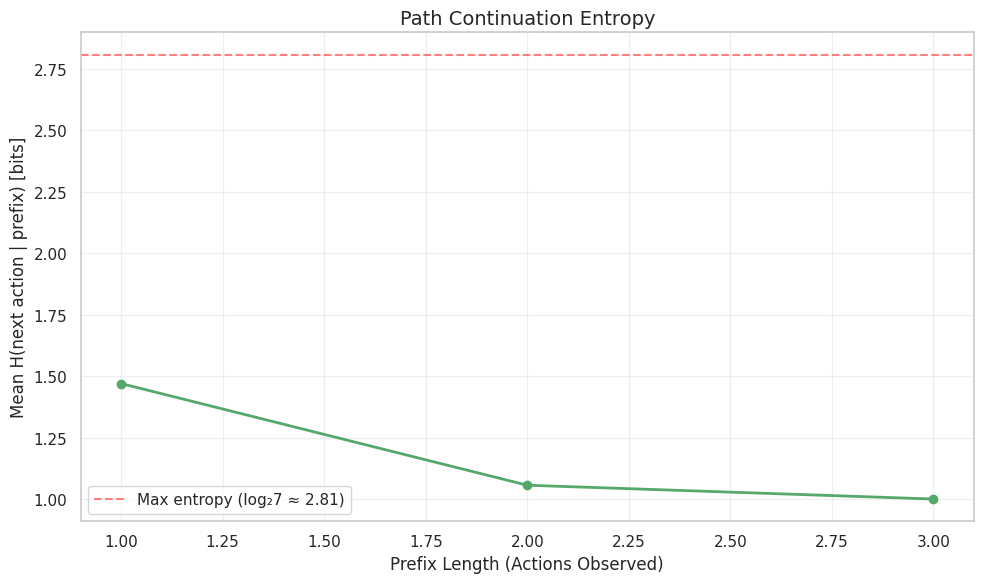

In [8]:
# Plot continuation entropy
if len(cont_df) > 0 and not cont_df['entropy'].isna().all():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    valid = cont_df.dropna(subset=['entropy'])
    ax.plot(valid['prefix_len'], valid['entropy'], 'g-o', markersize=6, linewidth=2)
    
    # Max entropy for 7 actions = log2(7) ≈ 2.81
    ax.axhline(y=np.log2(7), color='red', linestyle='--', alpha=0.5, label=f'Max entropy (log₂7 ≈ {np.log2(7):.2f})')
    
    ax.set_xlabel('Prefix Length (Actions Observed)', fontsize=12)
    ax.set_ylabel('Mean H(next action | prefix) [bits]', fontsize=12)
    ax.set_title('Path Continuation Entropy', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09g_continuation_entropy.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping continuation entropy plot (not enough data)")

## Analysis 3: Counterfactual Q-Gap Analysis

How much does the Q-gap (difference between best and second-best action) vary throughout the game?

In [9]:
# Analyze Q-gaps by position in game
q_gap_by_position = defaultdict(list)

for q_gaps in q_gap_sequences:
    for i, gap in enumerate(q_gaps):
        q_gap_by_position[i].append(gap)

# Compute statistics by position
q_gap_stats = []
for pos in sorted(q_gap_by_position.keys()):
    gaps = q_gap_by_position[pos]
    if len(gaps) >= 5:
        q_gap_stats.append({
            'position': pos,
            'mean_gap': np.mean(gaps),
            'std_gap': np.std(gaps),
            'median_gap': np.median(gaps),
            'pct_zero': sum(g == 0 for g in gaps) / len(gaps),
            'n_samples': len(gaps)
        })

qgap_df = pd.DataFrame(q_gap_stats)
print(qgap_df.to_string(index=False))

 position  mean_gap   std_gap  median_gap  pct_zero  n_samples
        0  3.500000  6.293421         0.0  0.678571         28
        1  1.357143  3.966055         0.0  0.857143         28
        2  3.000000  8.026741         0.0  0.857143         28
        3  3.285714 14.113968         0.0  0.857143         28
        4  6.785714  8.723356         2.0  0.357143         28
        5  1.285714  3.304295         0.0  0.821429         28
        6  3.000000  7.454625         0.0  0.821429         28
        7  0.428571  1.878992         0.0  0.928571         28
        8  5.357143  7.672838         2.0  0.464286         28
        9  0.642857  2.333212         0.0  0.928571         28
       10  3.142857  7.623808         0.0  0.785714         28
       11  5.000000 15.329710         0.0  0.750000         28
       12  6.571429  8.813255         2.0  0.464286         28
       13  1.142857  3.313547         0.0  0.892857         28
       14  4.142857  8.634293         0.0  0.714286    

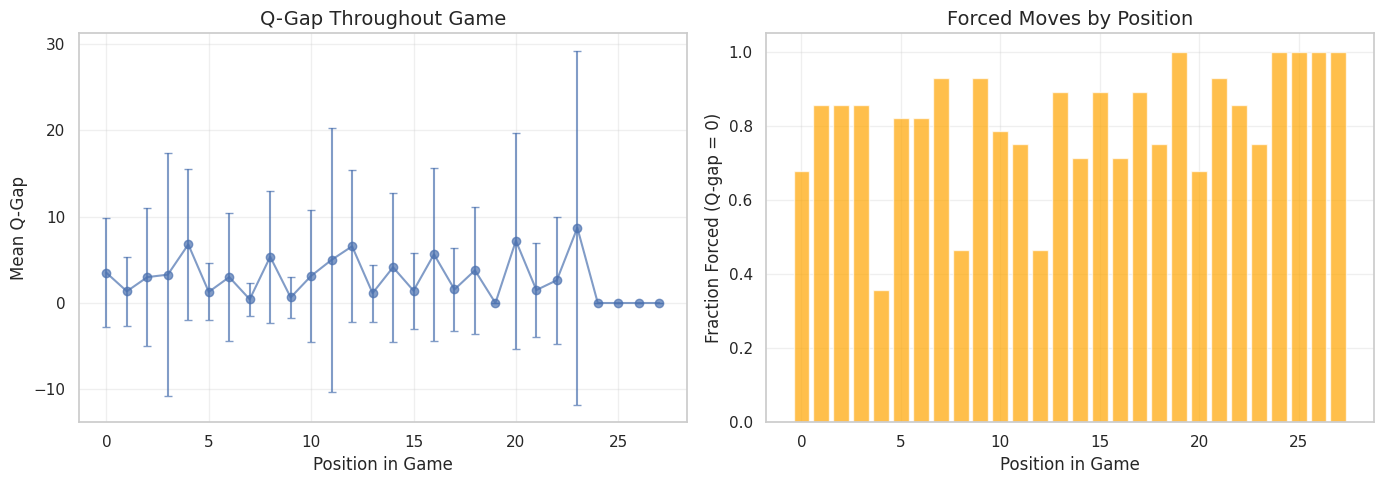

In [10]:
# Plot Q-gap by position
if len(qgap_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean Q-gap by position
    ax1.errorbar(qgap_df['position'], qgap_df['mean_gap'], 
                yerr=qgap_df['std_gap'], fmt='b-o', capsize=3, alpha=0.7)
    ax1.set_xlabel('Position in Game', fontsize=12)
    ax1.set_ylabel('Mean Q-Gap', fontsize=12)
    ax1.set_title('Q-Gap Throughout Game', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Percentage of forced moves (zero gap)
    ax2.bar(qgap_df['position'], qgap_df['pct_zero'], alpha=0.7, color='orange')
    ax2.set_xlabel('Position in Game', fontsize=12)
    ax2.set_ylabel('Fraction Forced (Q-gap = 0)', fontsize=12)
    ax2.set_title('Forced Moves by Position', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09g_qgap_by_position.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping Q-gap plot (not enough data)")

## Summary Statistics

In [11]:
# Find depth where prediction exceeds 90%
depth_90 = "N/A"
if len(pred_df) > 0:
    above_90 = pred_df[pred_df['accuracy'] >= 0.9]
    if len(above_90) > 0:
        depth_90 = above_90['depth'].min()

# Mean continuation entropy
mean_cont_entropy = cont_df['entropy'].mean() if len(cont_df) > 0 else np.nan

# Mean Q-gap
overall_mean_qgap = qgap_df['mean_gap'].mean() if len(qgap_df) > 0 else np.nan
overall_pct_forced = qgap_df['pct_zero'].mean() if len(qgap_df) > 0 else np.nan

# Create summary table
summary = {
    'metric': [
        'Total paths analyzed',
        'Unique basins',
        'Depth for 90% basin prediction',
        'Final prediction accuracy',
        'Mean continuation entropy [bits]',
        'Mean Q-gap',
        'Mean % forced moves',
    ],
    'value': [
        len(path_data),
        n_classes,
        depth_90,
        f"{pred_df['accuracy'].iloc[-1]:.3f}" if len(pred_df) > 0 else "N/A",
        f"{mean_cont_entropy:.2f}" if not np.isnan(mean_cont_entropy) else "N/A",
        f"{overall_mean_qgap:.1f}" if not np.isnan(overall_mean_qgap) else "N/A",
        f"{overall_pct_forced:.1%}" if not np.isnan(overall_pct_forced) else "N/A",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09g_prediction.csv', index=False)
print("\nSaved to results/tables/09g_prediction.csv")

                          metric value
            Total paths analyzed    28
                   Unique basins    14
  Depth for 90% basin prediction   N/A
       Final prediction accuracy   N/A
Mean continuation entropy [bits]  1.18
                      Mean Q-gap   2.9
             Mean % forced moves 80.9%

Saved to results/tables/09g_prediction.csv


## Conclusion

In [12]:
print("=" * 60)
print("PREDICTION ANALYSIS CONCLUSIONS")
print("=" * 60)

# Basin prediction
print(f"\n1. BASIN PREDICTION FROM EARLY MOVES")
if depth_90 != "N/A":
    trick = depth_90 // 4
    print(f"   90% accuracy at depth {depth_90} (after trick {trick})")
    if trick <= 2:
        print(f"   EARLY LOCK-IN: Basin mostly determined by trick 2")
        print(f"   Transformer can treat this as classification.")
    else:
        print(f"   LATE DETERMINATION: Basin requires later information")
        print(f"   Transformer needs genuine planning.")
else:
    final_acc = pred_df['accuracy'].iloc[-1] if len(pred_df) > 0 else 0
    print(f"   Never reaches 90% (best: {final_acc:.1%} at end)")
    print(f"   Basin prediction remains uncertain until late game.")

# Continuation entropy
print(f"\n2. PATH CONTINUATION PREDICTABILITY")
if not np.isnan(mean_cont_entropy):
    max_H = np.log2(7)
    ratio = mean_cont_entropy / max_H
    print(f"   Mean continuation entropy: {mean_cont_entropy:.2f} bits ({ratio:.0%} of max)")
    if ratio > 0.7:
        print(f"   HIGH UNCERTAINTY: Next moves are hard to predict.")
    elif ratio > 0.4:
        print(f"   MODERATE: Some predictability in move choices.")
    else:
        print(f"   LOW ENTROPY: Moves are fairly predictable.")
else:
    print(f"   Not enough data to assess.")

# Q-gap analysis
print(f"\n3. DECISION QUALITY (Q-GAP)")
if not np.isnan(overall_pct_forced):
    print(f"   Mean Q-gap: {overall_mean_qgap:.1f}")
    print(f"   Forced moves: {overall_pct_forced:.1%}")
    if overall_pct_forced > 0.5:
        print(f"   Many moves are forced (no real choice).")
    else:
        print(f"   Genuine choices exist at most positions.")
else:
    print(f"   Not enough data to assess.")

# Implication for transformer
print(f"\n4. IMPLICATION FOR TRANSFORMER TRAINING")
if depth_90 != "N/A" and depth_90 <= 8:
    print(f"   Classification approach may work well.")
    print(f"   Focus on early game pattern recognition.")
else:
    print(f"   Planning/search likely required.")
    print(f"   Basin outcome depends on mid/late game decisions.")

print("\n" + "=" * 60)

PREDICTION ANALYSIS CONCLUSIONS

1. BASIN PREDICTION FROM EARLY MOVES
   Never reaches 90% (best: 0.0% at end)
   Basin prediction remains uncertain until late game.

2. PATH CONTINUATION PREDICTABILITY
   Mean continuation entropy: 1.18 bits (42% of max)
   MODERATE: Some predictability in move choices.

3. DECISION QUALITY (Q-GAP)
   Mean Q-gap: 2.9
   Forced moves: 80.9%
   Many moves are forced (no real choice).

4. IMPLICATION FOR TRANSFORMER TRAINING
   Planning/search likely required.
   Basin outcome depends on mid/late game decisions.

